In [3]:
import shap
import pickle
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

plt.style.use({'figure.figsize':(15,10)})

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

In [4]:
df = pd.read_csv('data/bilibili_rank100_data.csv')

In [5]:
# 按标题去重
df = df.drop_duplicates(subset=['title'],keep='last',inplace=False)
# 缺失值处理
df = df.drop(df[df['time']>1000].index)
df[df.isnull().values==True]
# 重置索引
df=df.reset_index(drop=True, inplace=False)
# 分区按序号编码
def LabelEncoding(df):
    x, dfc = 'partition', df
    key = dfc[x].unique()  # 将唯一值作为关键字
    value = [i for i in range(len(key))]
    Dict = dict(zip(key, value))
    for i in range(len(key)):
        for j in range(dfc.shape[0]):
            if key[i] == dfc[x][j]:
                dfc[x][j] = Dict[key[i]]
    dfc[x] = dfc[x].astype(np.int64)
    return dfc

df = LabelEncoding(df)

In [6]:
df = df.drop(["author","title","tag"],axis = 1)
X = df.drop(["views"],axis = 1)
y = df["views"]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=99)

## 调整LightGBM的参数

调整 `max_depth` 和 `min_data_in_leaf` 参数

In [7]:
num_leaves = 31
learning_rate = 0.1
feature_fraction = 0.8
bagging_fraction = 0.8
bagging_freq = 5
reg_alpha = 1
reg_lambda = 1

parameters = {}
parameters['num_leaves'] = num_leaves    # 一棵树上的叶子数,控制树模型复杂度,小于 2^(max_depth)
parameters['learning_rate'] = learning_rate    # 学习速率，控制每次迭代更新权重时的步长
parameters['feature_fraction'] = feature_fraction    # 建树的特征选择比例
parameters['bagging_fraction'] = bagging_fraction    # 建树的样本采样比例
parameters['bagging_freq'] = bagging_freq    # k 意味着每k次迭代执行bagging
parameters['reg_alpha'] = reg_alpha    # L1正则化参数
parameters['reg_lambda'] = reg_lambda    # L2正则化参数

scores = []

cv_params = {'max_depth': [2,4,6,8],
             'min_data_in_leaf': [4,8,12,16,20],
            }

gbm = GridSearchCV(lgb.LGBMRegressor(
                                        boosting_type = 'gbdt',
                                        objective = "regression",
                                        seed = 99,
                                        num_leaves = num_leaves,
                                        learning_rate = learning_rate,
                                        feature_fraction = feature_fraction,
                                        bagging_fraction = bagging_fraction,
                                        bagging_freq = bagging_freq,
                                        reg_alpha = reg_alpha,
                                        reg_lambda = reg_lambda,
                                    ),
                    
                    param_grid = cv_params,
                    cv = 5,
)

gbm.fit(X_train,y_train)
print(gbm.cv_results_)
print("Best parameters %s" %gbm.best_params_)
print("Best score %s" %gbm.best_score_)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_by

In [8]:
max_depth = gbm.best_params_['max_depth']
min_data_in_leaf = gbm.best_params_['min_data_in_leaf']
parameters['max_depth'] = max_depth
parameters['min_data_in_leaf'] = min_data_in_leaf
scores.append(gbm.best_score_)

cv_params = {'max_depth': [max_depth-1, max_depth, max_depth+1], 
             'min_data_in_leaf': [min_data_in_leaf-1, min_data_in_leaf-0.5, min_data_in_leaf, min_data_in_leaf+0.5, min_data_in_leaf+1]
            }

gbm = GridSearchCV(lgb.LGBMRegressor(
                                        boosting_type = 'gbdt',
                                        objective = "regression",
                                        seed = 99,
                                        num_leaves = num_leaves,
                                        learning_rate = learning_rate,
                                        feature_fraction = feature_fraction,
                                        bagging_fraction = bagging_fraction,
                                        bagging_freq = bagging_freq,
                                        reg_alpha = reg_alpha,
                                        reg_lambda = reg_lambda,
                                    ),
                    
                    param_grid = cv_params,
                    cv = 5,
)

gbm.fit(X_train,y_train)
print(gbm.cv_results_)
print("Best parameters %s" %gbm.best_params_)
print("Best score %s" %gbm.best_score_)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_by

设置`max_depth`和`min_data_in_leaf`的参数

调整`num_leaves`和`learning_rate`参数

In [9]:
max_depth = gbm.best_params_['max_depth']
min_data_in_leaf = gbm.best_params_['min_data_in_leaf']
parameters['max_depth'] = max_depth
parameters['min_data_in_leaf'] = min_data_in_leaf
scores.append(gbm.best_score_)

cv_params = {'num_leaves': [4,6,8,10,12,14,16],
             'learning_rate':[i/10.0 for i in range(1,4)],
            }

gbm = GridSearchCV(lgb.LGBMRegressor(
                                        boosting_type = 'gbdt',
                                        objective = "regression",
                                        seed = 99,
                                        max_depth = max_depth,
                                        min_data_in_leaf = min_data_in_leaf,
                                        feature_fraction = feature_fraction,
                                        bagging_fraction = bagging_fraction,
                                        bagging_freq = bagging_freq,
                                        reg_alpha = reg_alpha,
                                        reg_lambda = reg_lambda,
                                    ),
                    
                    param_grid = cv_params,
                    cv = 5,
)

gbm.fit(X_train,y_train)
print(gbm.cv_results_)
print("Best parameters %s" %gbm.best_params_)
print("Best score %s" %gbm.best_score_)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_by

In [10]:
num_leaves = gbm.best_params_['num_leaves']
learning_rate = gbm.best_params_['learning_rate']
parameters['num_leaves'] = num_leaves
parameters['learning_rate'] = learning_rate
scores.append(gbm.best_score_)

cv_params = {'num_leaves': [num_leaves-1, num_leaves, num_leaves+1], 
             'learning_rate': [learning_rate-0.1, learning_rate-0.05, learning_rate, learning_rate+0.05, learning_rate+0.1]
            }

gbm = GridSearchCV(lgb.LGBMRegressor(
                                        boosting_type = 'gbdt',
                                        objective = "regression",
                                        seed = 99,
                                        max_depth = max_depth,
                                        min_data_in_leaf = min_data_in_leaf,
                                        feature_fraction = feature_fraction,
                                        bagging_fraction = bagging_fraction,
                                        bagging_freq = bagging_freq,
                                        reg_alpha = reg_alpha,
                                        reg_lambda = reg_lambda,
                                    ),
                    
                    param_grid = cv_params,
                    cv = 5,
)

gbm.fit(X_train,y_train)
print(gbm.cv_results_)
print("Best parameters %s" %gbm.best_params_)
print("Best score %s" %gbm.best_score_)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_by

设置`num_leaves`和`learning_rate`参数

调整`feature_fraction`，`bagging_fraction`和`bagging_freq`参数

In [11]:
num_leaves = gbm.best_params_['num_leaves']
learning_rate = gbm.best_params_['learning_rate']
parameters['num_leaves'] = num_leaves
parameters['learning_rate'] = learning_rate
scores.append(gbm.best_score_)

cv_params = {'feature_fraction': [i/10.0 for i in range(6,11)],
             'bagging_fraction': [i/10.0 for i in range(6,11)],
             'bagging_freq': [0,1,3,5,7,9]
            }


gbm = GridSearchCV(lgb.LGBMRegressor(
                                        boosting_type = 'gbdt',
                                        objective = "regression",
                                        seed = 99,
                                        max_depth = max_depth,
                                        min_data_in_leaf = min_data_in_leaf,
                                        num_leaves = num_leaves,
                                        learning_rate = learning_rate,
                                        reg_alpha = reg_alpha,
                                        reg_lambda = reg_lambda,
                                    ),
                    
                    param_grid = cv_params,
                    cv = 5,
)

gbm.fit(X_train,y_train)
print(gbm.cv_results_)
print("Best parameters %s" %gbm.best_params_)
print("Best score %s" %gbm.best_score_)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_by

设置`feature_fraction`，`bagging_fraction`和`bagging_freq`参数

调整`reg_alpha`和`reg_lambda`参数

In [12]:
feature_fraction = gbm.best_params_['feature_fraction']
bagging_fraction = gbm.best_params_['bagging_fraction']
bagging_freq = gbm.best_params_['bagging_freq']
parameters['feature_fraction'] = feature_fraction
parameters['bagging_fraction'] = bagging_fraction
parameters['bagging_freq'] = bagging_freq
scores.append(gbm.best_score_)

cv_params = {'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100], 
             'reg_lambda': [1e-5, 1e-2, 0.1, 1, 100]
            }

gbm = GridSearchCV(lgb.LGBMRegressor(
                                        boosting_type = 'gbdt',
                                        objective = "regression",
                                        seed = 99,
                                        max_depth = max_depth,
                                        min_data_in_leaf = min_data_in_leaf,
                                        num_leaves = num_leaves,
                                        learning_rate = learning_rate,
                                        feature_fraction = feature_fraction,
                                        bagging_fraction = bagging_fraction,
                                        bagging_freq = bagging_freq,
                                    ),
                    
                    param_grid = cv_params,
                    cv = 5,
)

gbm.fit(X_train,y_train)
print(gbm.cv_results_)
print("Best parameters %s" %gbm.best_params_)
print("Best score %s" %gbm.best_score_)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_by

In [13]:
reg_alpha = gbm.best_params_['reg_alpha']
reg_lambda = gbm.best_params_['reg_lambda']
parameters['reg_alpha'] = reg_alpha
parameters['reg_lambda'] = reg_lambda
scores.append(gbm.best_score_)

In [30]:
parameters['feature_pre_filter'] = 'false'
parameters['objective'] = 'regression'

## 打印最终参数和获得的分数

确保分数随着每次迭代而增加

In [31]:
print(parameters)
print(scores)

{'num_leaves': 11, 'learning_rate': 0.25, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'reg_alpha': 100, 'reg_lambda': 0.1, 'max_depth': 4, 'min_data_in_leaf': 7, 'feature_pre_filter': 'false', 'objective': 'regression'}
[0.7377263225053228, 0.7453112638191308, 0.7863838149402165, 0.802260087182726, 0.802260087182726, 0.8045429454656986]


数据格式转换

In [32]:
lgb_train = lgb.Dataset(data = X_train, label = y_train, free_raw_data = False)
lgb_test = lgb.Dataset(data = X_test, label = y_test, reference = lgb_train, free_raw_data = False)

通过交叉验证，找到最好的树

In [33]:
num_boost_round = 1000
early_stopping_rounds = 10
nfold = 2
evals_result = {}

gbmCV = lgb.cv(params = parameters, 
               train_set = lgb_train,
               num_boost_round = num_boost_round,
               nfold = nfold,
               early_stopping_rounds = early_stopping_rounds,
               verbose_eval = True,
               )

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2313
[LightGBM] [Info] Number of data points in the train set: 2368, number of used features: 10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2313
[LightGBM] [Info] Number of data points in the train set: 2368, number of used features: 10
[LightGBM] [Info] Start training from score 751397.197213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 683541.904139
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	cv_agg's l2: 5.47106e+12 + 1.08878e+12
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

确定最终LightGBM模型

In [34]:
num_boost_round = len(gbmCV['l2-mean'])

lgbFinal = lgb.train(
                params = parameters,
                train_set = lgb_train,
                num_boost_round = num_boost_round,
                valid_sets = [lgb_test],
                valid_names = ['eval'],
                evals_result = evals_result,
                verbose_eval = True
               )

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2313
[LightGBM] [Info] Number of data points in the train set: 4736, number of used features: 10
[LightGBM] [Info] Start training from score 717469.550676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	eval's l2: 7.97865e+11
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	eval's l2: 6.08752e+11
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	eval's l2: 5.21705e+11
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	eval's l2: 4.70927e+11
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	eval's l2: 4.74839e+11
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	eval's l2: 4.89933e+11
[LightGBM] [Warning] No further splits 

绘制特征重要性图并打印数值

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

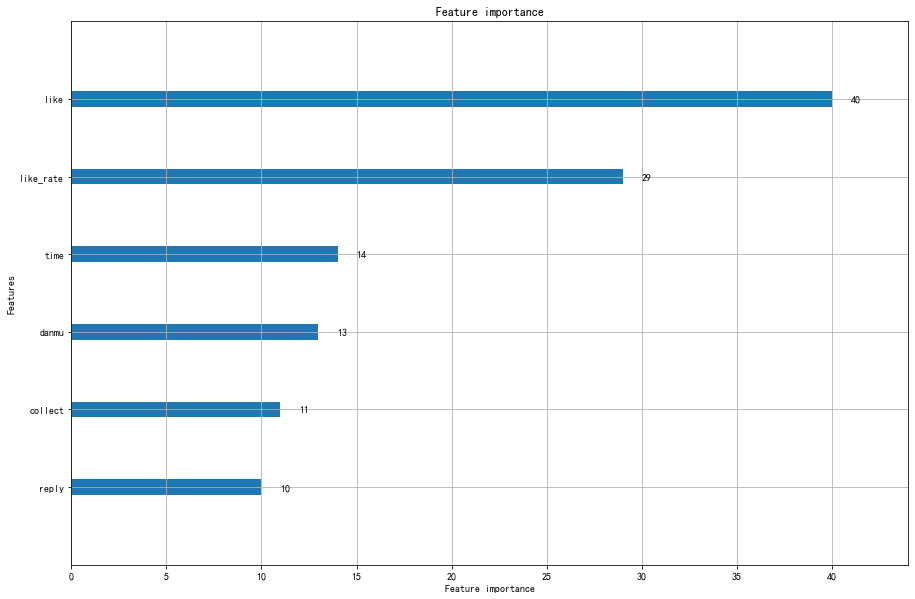

In [35]:
lgb.plot_importance(lgbFinal, max_num_features = 6, importance_type='split')

In [36]:
importance = pd.DataFrame()
importance['Feature'] = X_train.columns.values
importance['ImportanceWeight'] = lgbFinal.feature_importance(importance_type = 'split')
importance['ImportanceGain'] = lgbFinal.feature_importance(importance_type = 'gain')

importance.sort_values(by = 'ImportanceWeight', ascending = False, inplace = True)
importance.head()

,Feature,ImportanceWeight,ImportanceGain
2,like,40,6.285536e+15
9,like_rate,29,8.500591e+15
8,time,14,1.967300e+15
6,danmu,13,1.069065e+16
4,collect,11,5.022785e+15


#### 对训练集和测试集进行预测

In [37]:
lgbFinal_train_preds = lgbFinal.predict(X_train, num_iteration = lgbFinal.best_iteration)
lgbFinal_test_preds = lgbFinal.predict(X_test, num_iteration = lgbFinal.best_iteration)


In [38]:
print(lgbFinal_train_preds.shape)
print(lgbFinal_test_preds.shape)

(4736,)
(1184,)


#### 计算MSE均方误差和RMSE均方根误差

In [39]:
print("\nModel Report")
print("MSE Train : %f" % mean_squared_error(y_train, lgbFinal_train_preds))
print("MSE Test: %f" % mean_squared_error(y_test, lgbFinal_test_preds))
print("RMSE Train: %f" % mean_squared_error(y_train, lgbFinal_train_preds)**0.5)
print("RMSE Test: %f" % mean_squared_error(y_test, lgbFinal_test_preds)**0.5)


Model Report
MSE Train : 1305516153422.088135
MSE Test: 690802913180.571167
RMSE Train: 1142591.857761
RMSE Test: 831145.542718


将模型打包成pkl文件

In [40]:
pickle.dump(lgbFinal, open("lgbFinal.pkl", "wb"))

In [25]:
# train_preds = pd.DataFrame(lgbFinal_train_preds)
# test_preds = pd.DataFrame(lgbFinal_test_preds)
# train_preds.columns = ['views']
# test_preds.columns = ['views']

In [26]:
# train_preds.to_csv('XGBoost_Train_Preds.csv', sep=',')
# test_preds.to_csv('XGBoost_Test_Preds.csv', sep=',')